In [ ]:
#import libraries
import tensorflow as tf

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import keras


from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras import regularizers


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#Basic libraries
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import yellowbrick as yb
from matplotlib.colors import ListedColormap
#from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
#import kmapper as km
from sklearn.cluster import KMeans
from sklearn.metrics import plot_roc_curve

from IPython.display import set_matplotlib_formats 
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[1], sns.color_palette(color)[0]]
four_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0], sns.color_palette(color)[2]]

In [ ]:
#Read data
df = pd.read_csv('/content/sample_data/METABRIC_RNA_Mutation.csv', delimiter=',')

nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.shape

There are 1904 rows and 693 columns


(1904, 693)

In [ ]:
# Relationship between clinical attributes and outcomes
# create a new dataframe for clinical attributes only
clinical_features_to_drop = df.columns[31:] # non clinical attributes
clinical_df = df.drop(clinical_features_to_drop, axis=1)
clinical_df.shape


(1904, 31)

In [ ]:
#Classification with only clinical attributes
categorical_columns = clinical_df.select_dtypes(include=['object']).columns.tolist()
unwanted_columns = ['patient_id','death_from_cancer' ]
categorical_columns = [ele for ele in categorical_columns if ele not in unwanted_columns] 
# Getting dummies for all categorical columns, convert categorical columns to numerical columns and increase column numbers
dummies_clinical_df = pd.get_dummies(clinical_df.drop('patient_id',axis=1 ), columns= categorical_columns, dummy_na=True)
dummies_clinical_df.dropna(inplace = True)

In [ ]:
dummies_clinical_df.shape

(1309, 95)

In [ ]:
# data splitting to train and test data
X = dummies_clinical_df.drop(['death_from_cancer', 'overall_survival'], axis=1)
y = dummies_clinical_df['overall_survival']

# using stratify for y because we need the distribution of the two classes to be equal in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

In [ ]:
def model_metrics(model, kfold, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)

    #metrics
    results = cross_val_score(model, X_train, y_train, cv = kfold)
    print("CV scores: ", results); print("CV Standard Deviation: ", results.std()); print();
    print('CV Mean score: ', results.mean()); 
    print('Train score:   ', model.score(X_train, y_train))
    print('Test score:    ', model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    # CODE HERE PLEASE
    print()
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, pred))
    print('Classification Report:  ')
    print(classification_report(y_test, pred))
    train_score =  model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_pred = model.predict(X_test)
    return test_pred, test_score, results.mean()

In [ ]:
def basic_classifiers (X_train, X_test, y_train, y_test, kfold):
    BOLD = '\033[1m'
    END = '\033[0m'
    
    # Scaling 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    ######################################################################################################  K Neighbors Classifier model
    knn_params = {
    "n_neighbors" : [5,15,25,30,35,40, 100],
    "weights" : ["uniform" , "distance"]
    }
    print(); print(BOLD + 'K Neighbors Classifier Model:' + END)

    knn= GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=4)
    knn_pred, knn_test, knn_train = model_metrics(knn, kfold, X_train, X_test, y_train, y_test)
    ###################################################################################################### Logistic Regression
    lg_params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-2,4,100)
    }
    print(); print(BOLD + 'Logistic Regression Model:' + END)
    logistic_regression = GridSearchCV(LogisticRegression(random_state=42), lg_params, n_jobs=-1, cv=4)
    lg_pred, lg_test, lg_train = model_metrics(logistic_regression, kfold, X_train, X_test, y_train, y_test)
    ###################################################################################################### Decision Tree
    print(); print(BOLD + 'Decision Tree Classifier Model:' + END)
    decision_tree = DecisionTreeClassifier(random_state=42)
    dt_pred, dt_test, dt_train = model_metrics(decision_tree, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### Random Forest Classifier
    rf_params = {
        #'n_estimators': [10, 50, 100, 150, 200, 250],
        'max_features':[2, 3, 5, 7, 8],
        #'max_depth': [1, 2, 3, 4, 5, 8],
        #'criterion':['gini', 'entropy'],
    }

    print(); print(BOLD + 'Random Forest Classifier Model:' + END)
    random_forest = RandomForestClassifier(n_estimators=100)
    rf = GridSearchCV(random_forest, param_grid=rf_params, cv=4, verbose = 1)
    rf_pred, rf_test, rf_train = model_metrics(rf, kfold, X_train, X_test, y_train, y_test)
        
    #random_forest = RandomForestClassifier(random_state=42)
    #rf_pred, rf_test, rf_train = model_metrics(random_forest, kfold, X_train, X_test, y_train, y_test)
    ###################################################################################################### Extra Trees Classifier
   
    et_params = {
        #'n_estimators': [10, 100, 400, 800, 1100, 1850],
        #'max_features':['auto'],
        'max_depth': [1, 2, 3, 4, 5, 8],
        #'criterion':['gini'],
    }
    print(); print(BOLD + 'Extra Trees Classifier Model:' + END)
    extra_trees = ExtraTreesClassifier(n_estimators=100)    
    et = GridSearchCV(extra_trees, param_grid=et_params, cv=4, verbose = 1)
    et_pred, et_test, et_train = model_metrics(et, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### AdaBoost Classifier
    ada_params = {
        'n_estimators': [10, 100, 400, 800, 1100, 1850],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
        #'max_features':['auto'],
        #'max_depth': [1, 2, 3, 4, 5, 8],
        #'criterion':['gini'],
    }
    print(); print(BOLD + 'AdaBoost Classifier Model:' + END)   
    #ada_boost = GridSearchCV(AdaBoostClassifier(), param_grid=ada_params)
    ada_boost = AdaBoostClassifier(random_state=42)
    ab_pred, ab_test, ab_train = model_metrics(ada_boost, kfold, X_train, X_test, y_train, y_test)
    
    ###################################################################################################### SVC Classifier
    
    print(); print(BOLD + 'SVC Classifier Model:' + END)
    svc_params={
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.001, 0.01, 0.1, 1, 10],
        'gamma':  [0.001, 0.01, 0.1, 1]
    }
    #svc=GridSearchCV(SVC(), param_grid=svc_params)
    svc = SVC(random_state=42)
    svc_pred, svc_test, svc_train = model_metrics(svc, kfold, X_train, X_test, y_train, y_test)
    ####################Chart 1
    print(); print(BOLD + 'XG Boost Classifier Model:' + END)
    xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

    clinical_xgb1_pred_, clinical_xgb1_test_score, clinical_xgb1_cv_score = model_metrics(xgb1, kfold, X_train, X_test, y_train, y_test)
    
    #######################Chart2
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
    #bar chart of accuracy scores
    inds = range(1,9)
    labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Extra Trees', 'AdaBoost', 'SVC', 'XG Boost']
    scores_all = [knn_train, lg_train, dt_train, rf_train, et_train, ab_train, svc_train, clinical_xgb1_cv_score]
    scores_predictive = [knn_test, lg_test, dt_test, rf_test, et_test, ab_test, svc_test, clinical_xgb1_test_score]
    
    ax1.bar(inds, scores_all, color=sns.color_palette(color)[5], alpha=0.3, hatch="x", edgecolor="none",label="CrossValidation Set")
    ax1.bar(inds, scores_predictive, color=sns.color_palette(color)[1], label="Testing set")
    ax1.set_ylim(0.4, 1)
    ax1.set_ylabel("Accuracy score")
    ax1.axhline(0.5793, color="black", linestyle="--")
    ax1.set_title("Accuracy scores for basic models", fontsize=17)
    ax1.set_xticks(range(1,9))
    ax1.set_xticklabels(labels, size=12, rotation=40, ha="right")
    ax1.legend()
    labels = ["KNN", "Logistic Regression", "Decision Tree", "Random Forest",'Extra Trees', 'AdaBoost', 'SVC', 'XG Boost' ]
    for label, pred in zip(labels, [knn_pred, lg_pred, dt_pred, rf_pred, et_pred, ab_pred, svc_pred, clinical_xgb1_pred_]):
        fpr, tpr, threshold = roc_curve(y_test.values, pred)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=label+' (area = %0.2f)' % roc_auc, linewidth=2)
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right", prop={'size': 12})
    ax2.set_title("Roc curve for basic models", fontsize=17)

    plt.show()


K Neighbors Classifier Model:
CV scores:  [0.68686869 0.65306122 0.68367347 0.70408163 0.64285714 0.66326531
 0.67346939 0.69387755 0.63265306 0.71428571]
CV Standard Deviation:  0.025315971269166498

CV Mean score:  0.6748093176664605
Train score:    1.0
Test score:     0.6676829268292683

Confusion Matrix: 
[[157  29]
 [ 80  62]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.66      0.84      0.74       186
           1       0.68      0.44      0.53       142

    accuracy                           0.67       328
   macro avg       0.67      0.64      0.64       328
weighted avg       0.67      0.67      0.65       328


Logistic Regression Model:
CV scores:  [0.72727273 0.73469388 0.68367347 0.73469388 0.78571429 0.75510204
 0.78571429 0.70408163 0.71428571 0.73469388]
CV Standard Deviation:  0.03101217367692645

CV Mean score:  0.7359925788497217
Train score:    0.7747196738022426
Test score:     0.7774390243902439

Confusion

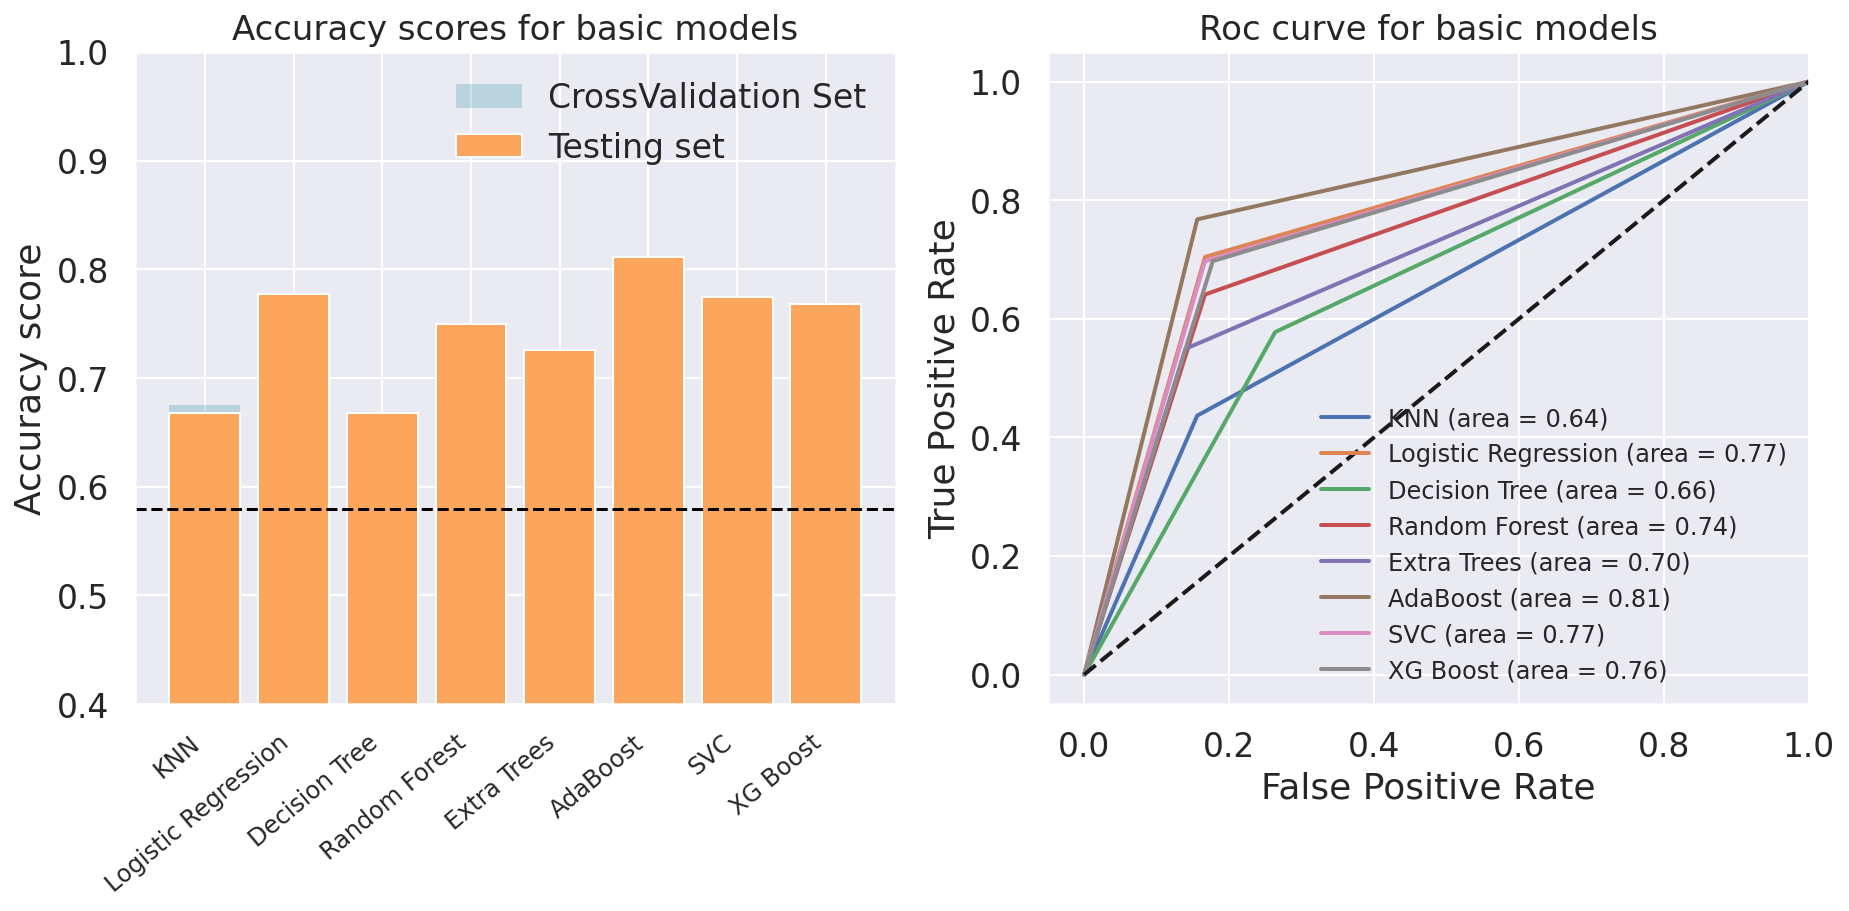

In [ ]:
# using a stratfied k fold because we need the distribution of the to classes in all of the folds to be the same.
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
basic_classifiers( X_train, X_test, y_train, y_test, kfold)

In [ ]:
# Clinical data only: DL CNN - Relu and sigmoid 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import SGD
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
	model = Sequential()
	model.add(Dense(17,input_shape=(93,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')


# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history


history = model.fit(X_train, y_train, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

Epoch 136: early stopping


11/11 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.7774
Test loss:  0.45534199476242065
Test accuracy:  0.7774389982223511


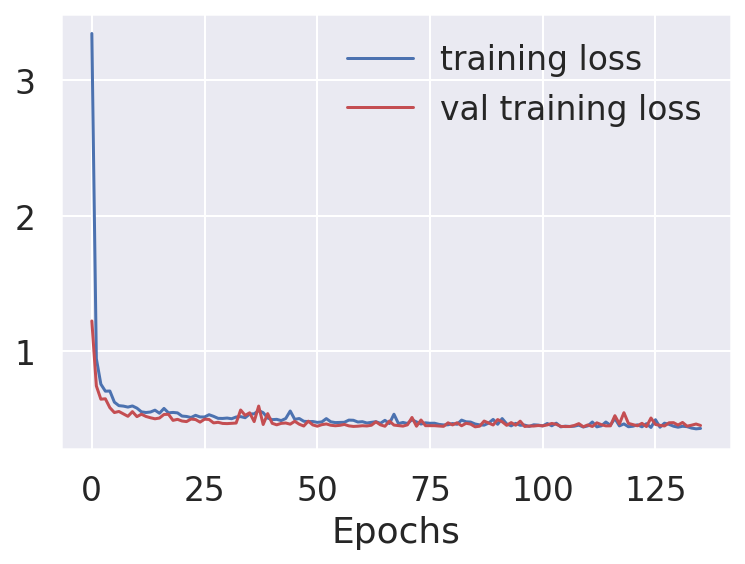

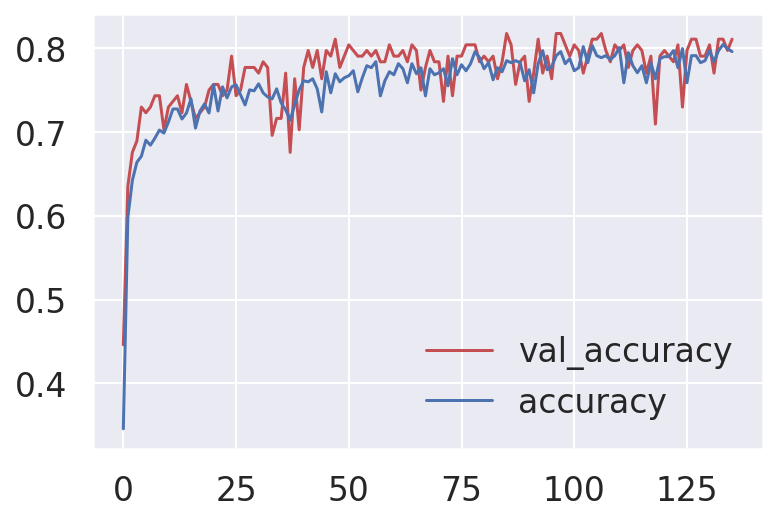

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()

plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
loss, acc = model.evaluate(X_test, y_test)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

Testing data AUC:  0.869794033015296


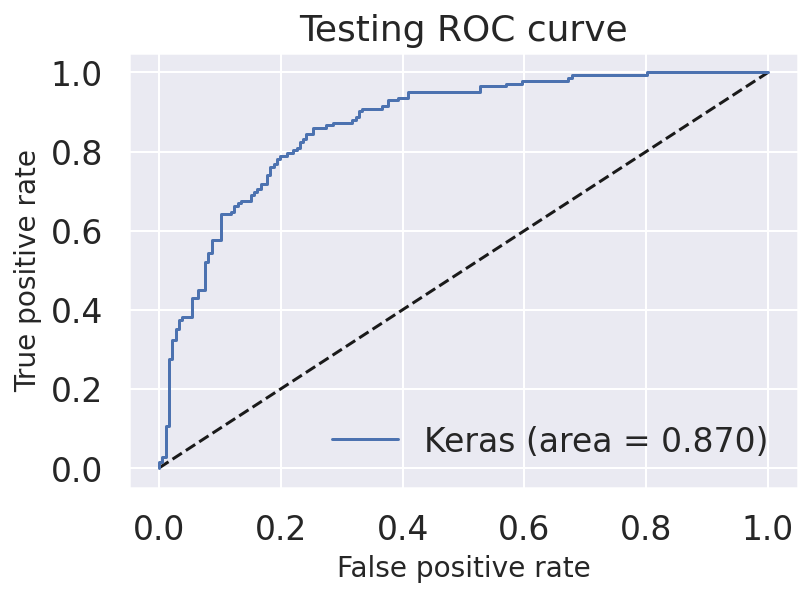

Training data AUC:  0.8810664409648751


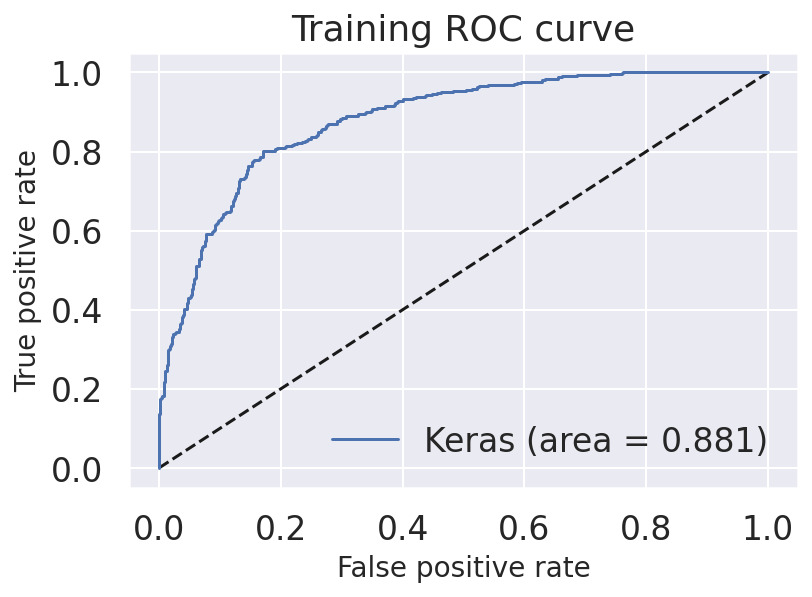

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Testing ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train,y_train_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)
# ROC curve of training data
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

[[157  29]
 [ 44  98]]

Class         Precision    Recall    f1-Score    Support
------------  -----------  --------  ----------  ---------
0             0.78         0.84      0.81        186
1             0.77         0.69      0.73        142

accuracy                             0.78        372
macro avg     0.78         0.77      0.77        372
weighted avg  0.78         0.77      0.77        372



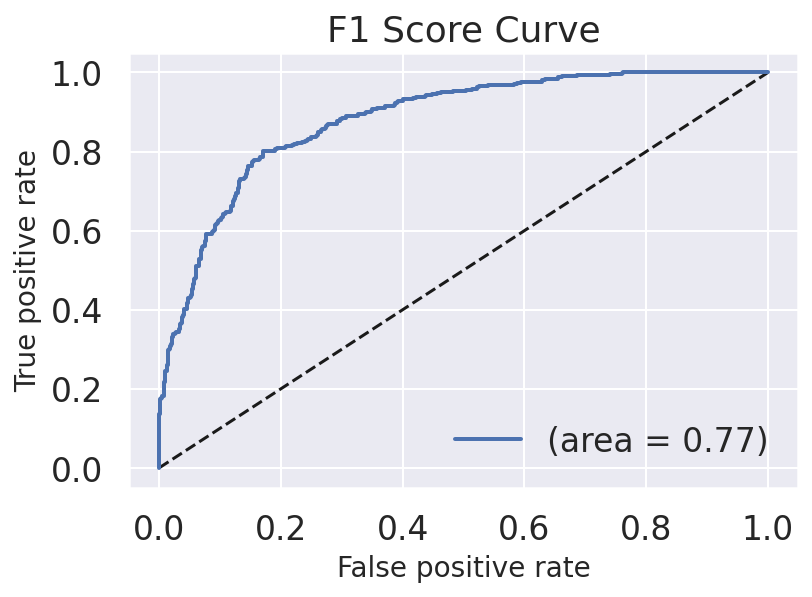

In [ ]:
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
#cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
                                       
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

#print('Class 0 Recall = {:.2f}'.format(C0Recall))
#print('Class 0 f1 score = {:.2f}'.format(C0f1score))

#print()# Print a new line 
#print('Class 1 Precision = {:.2f}'.format(Precision))
#print('Class 1 Recall = {:.2f}'.format(Recall))
#print('Class 1 f1 score = {:.2f}'.format(f1score))
#print()# Print a new line 
#print('Average f1 score = {:.2f}'.format(Ave_f1score))
#print('Testing Accuracy = {:.2f} '.format( (TP + TN) / (TP + TN + FN + FP)))
#print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Clinical data only: DL CNN - softmax 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
  #Define a "shallow" softmax regression model

  model = Sequential()
  model.add(Dense(17,input_shape=(93,), activation='softmax'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ['accuracy'])
  #Define a "shallow" softmax regression model


In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
y_train_cat = to_categorical(y_train)
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history
history = model.fit(X_train, y_train_cat, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

Epoch 82: early stopping


11/11 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5671
Test loss:  0.6849537491798401
Test accuracy:  0.5670731663703918


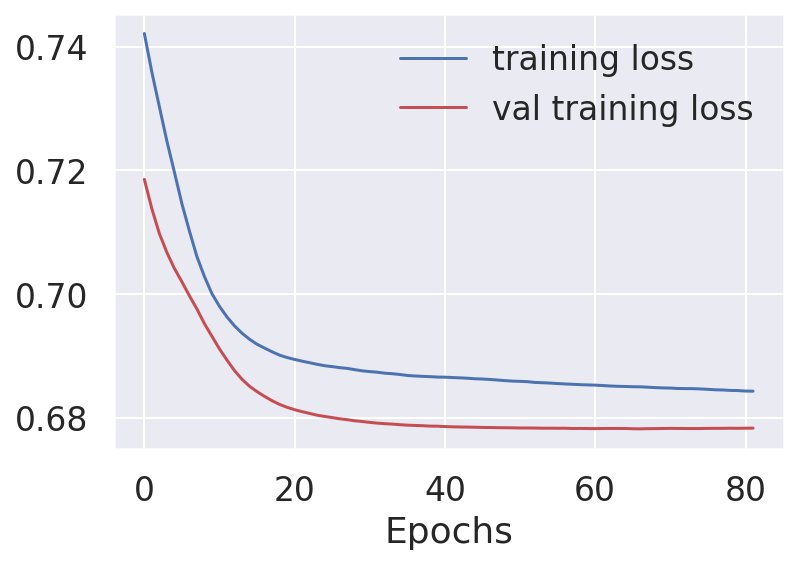

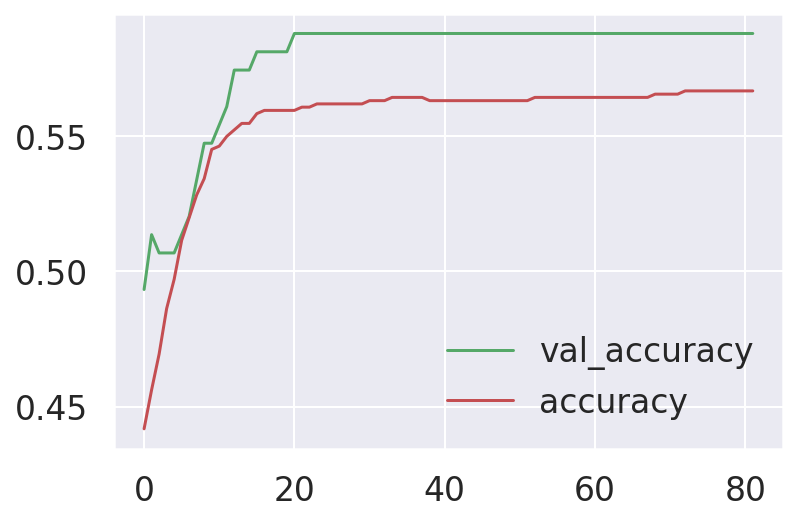

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()

plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")
# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()
# Calculate loss and accuracy of testing data
y_test_cat = to_categorical(y_test)
loss, acc = model.evaluate(X_test, y_test_cat)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

Testing data AUC:  0.34401029834923513


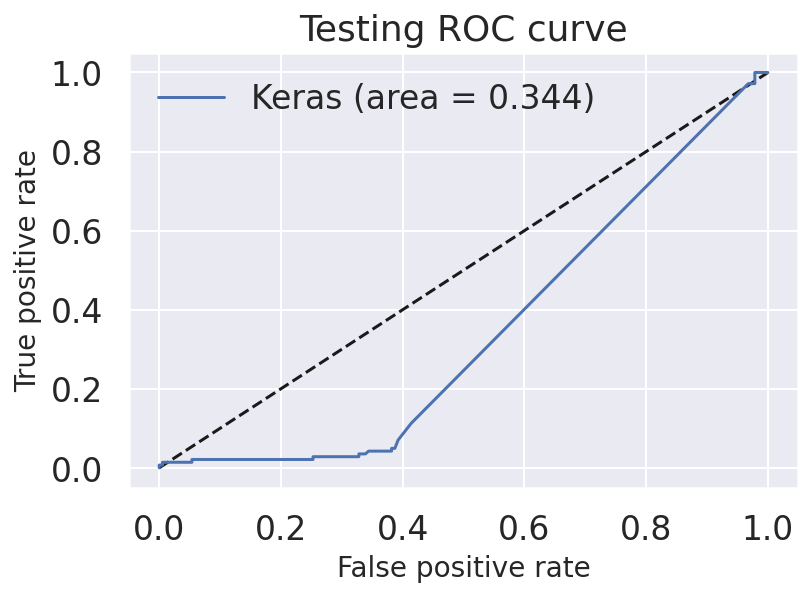

Training data AUC:  0.3731612357173086


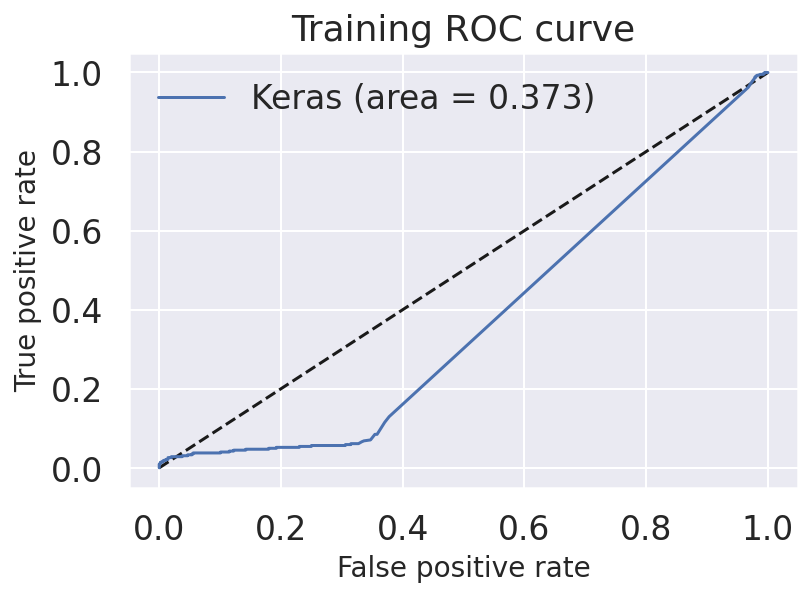

In [ ]:
# AUC score of testing data
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('Testing ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_train_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)

# ROC curve of training data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()


[[185   1]
 [141   1]]

Class         Precision    Recall    f1-Score    Support
------------  -----------  --------  ----------  ---------
0             0.57         0.99      0.72        186
1             0.50         0.01      0.01        142

accuracy                             0.57        372
macro avg     0.53         0.50      0.37        372
weighted avg  0.53         0.50      0.37        372



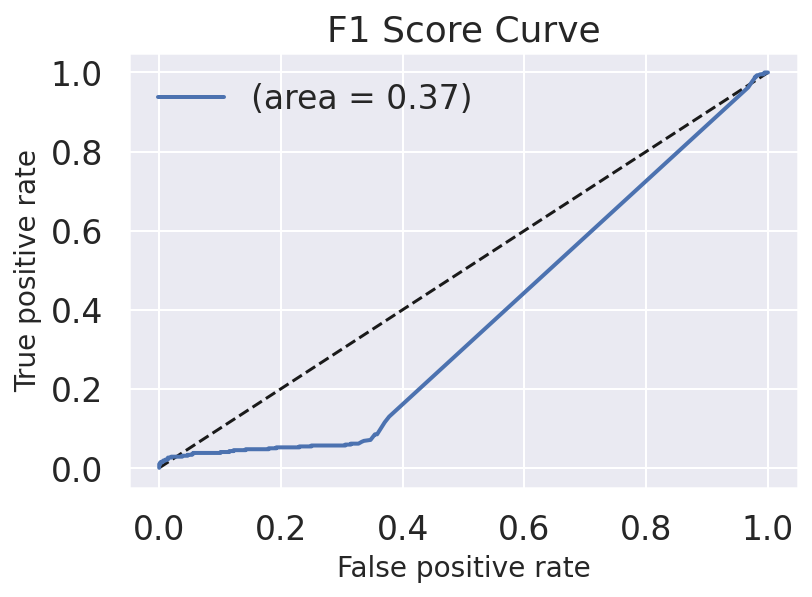

In [ ]:
#Clinical data only: DL CNN - F1 Score 
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
#print(preds)
#return only 1 value from the softmax probability
y_pred = np.argmax(preds, axis=-1)

#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Classficiation with genetics only data
# dropping mutations
genetic_features_to_drop = df.columns[520:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
genetic_features_to_drop = genetic_df.columns[4:35]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)
genetic_df = genetic_df.drop(['age_at_diagnosis','type_of_breast_surgery', 'cancer_type'], axis=1)
genetic_df = genetic_df.iloc [:,:-174]
genetic_df.shape


(1904, 312)

In [ ]:
# dropping mutations
genetic_features_to_drop = df.columns[520:]
genetic_df = df.drop(genetic_features_to_drop, axis=1)
# droping clinical data
genetic_features_to_drop = genetic_df.columns[4:35]
genetic_df = genetic_df.drop(genetic_features_to_drop, axis=1)
genetic_df = genetic_df.drop(['age_at_diagnosis','type_of_breast_surgery', 'cancer_type'], axis=1)
genetic_df = genetic_df.iloc [:,:-174]
genetic_df['overall_survival']= df['overall_survival']

In [ ]:
X = genetic_df.drop(['patient_id', 'overall_survival'], axis=1)
y = genetic_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
basic_classifiers( X_train, X_test, y_train, y_test, kfold)



K Neighbors Classifier Model:
CV scores:  [0.64052288 0.64052288 0.65359477 0.56578947 0.67105263 0.64473684
 0.64473684 0.61184211 0.64473684 0.63815789]
CV Standard Deviation:  0.02706306800491638

CV Mean score:  0.6355693154454765
Train score:    1.0
Test score:     0.6299212598425197

Confusion Matrix: 
[[166  55]
 [ 86  74]]
Classification Report:  
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       221
           1       0.57      0.46      0.51       160

    accuracy                           0.63       381
   macro avg       0.62      0.61      0.61       381
weighted avg       0.62      0.63      0.62       381


Logistic Regression Model:
CV scores:  [0.67320261 0.69934641 0.66013072 0.65131579 0.60526316 0.61184211
 0.625      0.67105263 0.61842105 0.61842105]
CV Standard Deviation:  0.030269152386645747

CV Mean score:  0.6433995528035774
Train score:    0.7636244254760342
Test score:     0.6089238845144357

Confusion

In [ ]:
y.shape

In [ ]:
#Genetic data only - DL CNN 1 
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
	model = Sequential()
	model.add(Dense(17, input_dim=311, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics = ['accuracy'])
	# Fit the model
	

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')


# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history


history = model.fit(X_train, y_train, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")
# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
loss, acc = model.evaluate(X_test, y_test)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Testing ROC curve')
plt.legend(loc='best')
plt.show()
# AUC score of training data
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train,y_train_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)
# ROC curve of training data
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Genetics data only - CNN 1 F1 Score
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
#cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
                                       
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

#print('Class 0 Recall = {:.2f}'.format(C0Recall))
#print('Class 0 f1 score = {:.2f}'.format(C0f1score))

#print()# Print a new line 
#print('Class 1 Precision = {:.2f}'.format(Precision))
#print('Class 1 Recall = {:.2f}'.format(Recall))
#print('Class 1 f1 score = {:.2f}'.format(f1score))
#print()# Print a new line 
#print('Average f1 score = {:.2f}'.format(Ave_f1score))
#print('Testing Accuracy = {:.2f} '.format( (TP + TN) / (TP + TN + FN + FP)))
#print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Genetic data only - DL CNN 2
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
  #Define a "shallow" softmax regression model

  model = Sequential()
  model.add(Dense(17,input_shape=(311,), activation='softmax'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ['accuracy'])

In [ ]:
y_train_cat = to_categorical(y_train)
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history
history = model.fit(X_train, y_train_cat, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

# Plot accuracy over the epochs
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
y_test_cat = to_categorical(y_test)
loss, acc = model.evaluate(X_test, y_test_cat)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)
# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate', fontsize = 14)
plt.ylabel('True positive rate', fontsize = 14)
plt.title('Testing ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_train_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)
# ROC curve of training data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate', fontsize = 14)
plt.ylabel('True positive rate', fontsize = 14)
plt.title('Training ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Genetic data only - DL CNN 2 F1 Score
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
#print(preds)
#return only 1 value from the softmax probability
y_pred = np.argmax(preds, axis=-1)

#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Classification with All attributes
features_to_drop = df.columns[520:]
df = df.drop(features_to_drop, axis=1)
all_categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
unwanted_columns = ['patient_id','death_from_cancer' ]
all_categorical_columns = [ele for ele in all_categorical_columns if ele not in unwanted_columns] 
dummies_df = pd.get_dummies(df.drop('patient_id',axis=1 ), columns= all_categorical_columns, dummy_na=True)
dummies_df.dropna(inplace = True)

In [ ]:
dummies_df.shape

In [ ]:
# data splitting
X = dummies_df.drop( ['death_from_cancer','overall_survival'], axis=1)
y = dummies_df['overall_survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
dummies_df.shape

In [ ]:
basic_classifiers( X_train, X_test, y_train, y_test, kfold)


In [ ]:
#All attributes - DL CNN 1 
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):

    model = Sequential()
    model.add(Dense(17,input_shape=(582,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'

earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')


# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history

history = model.fit(X_train, y_train, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-r',label='val_accuracy')
plt.plot(accuracy_values,'-b',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
loss, acc = model.evaluate(X_test, y_test)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train,y_train_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)

# ROC curve of training data
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#All Attributes - DL CNN 1 F1 Score
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
#cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Make y_train categorical and assign this to y_train_cat
y_train_cat = to_categorical(y_train)

In [ ]:
#All attributes - DL CNN 2 
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
#Define a "shallow" softmax regression model

    model = Sequential()
    model.add(Dense(17,input_shape=(582,), activation='softmax'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ['accuracy'])

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history
history = model.fit(X_train, y_train_cat, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
y_test_cat = to_categorical(y_test)
loss, acc = model.evaluate(X_test, y_test_cat)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_train_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)

# ROC curve of training data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# All attributes DL CNN 2 F1 Score
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
#print(preds)
#return only 1 value from the softmax probability
y_pred = np.argmax(preds, axis=-1)

#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#All attributes - DL CNN 2 
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
#Define a "shallow" softmax regression model

    model = Sequential()
    model.add(Dense(17,input_shape=(582,), activation='softmax'))
    model.add(Dense(17, activation='softmax'))
    model.add(Dense(17, activation='softmax'))
    model.add(Dense(17, activation='softmax'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history
history = model.fit(X_train, y_train_cat, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")

# Plot accuracy over the epochs
accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()

# Calculate loss and accuracy of testing data
y_test_cat = to_categorical(y_test)
loss, acc = model.evaluate(X_test, y_test_cat)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_train_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)

# ROC curve of training data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
#print(preds)
#return only 1 value from the softmax probability
y_pred = np.argmax(preds, axis=-1)

#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#All attributes - DL CNN 2 
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
#Define a "shallow" softmax regression model

# Dropout (no significant impact)
# Define a "deep" softmax regression model
    model = Sequential()
    model.add(Dense(17,input_shape=(582,), activation='softmax'))
    model.add(Dropout(0.3))
    model.add(Dense(17, activation='softmax'))
    model.add(Dropout(0.3))
    model.add(Dense(17, activation='softmax'))
    model.add(Dropout(0.3))
    model.add(Dense(17, activation='softmax'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
# Pass several parameters to 'EarlyStopping' function and assign it to 'earlystopper'
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

# Fit model over 2000 iterations with 'earlystopper' callback, and assign it to history
history = model.fit(X_train, y_train_cat, epochs = 2000, validation_split = 0.15, verbose = 0, 
                    callbacks = [earlystopper])

history_dict=history.history

In [ ]:
# Plot training loss and validation split loss over the epochs

loss_values = history_dict['loss']
val_loss_values=history_dict['val_loss']
plt.figure()
plt.plot(loss_values,'b',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.legend()
plt.xlabel("Epochs")
# Plot accuracy over the epochs

accuracy_values = history_dict['accuracy']
val_accuracy_values=history_dict['val_accuracy']
plt.figure()
plt.plot(val_accuracy_values,'-g',label='val_accuracy')
plt.plot(accuracy_values,'-r',label='accuracy')
plt.legend()
# Calculate loss and accuracy of testing data
y_test_cat = to_categorical(y_test)
loss, acc = model.evaluate(X_test, y_test_cat)
print("Test loss: ", loss)
print("Test accuracy: ", acc)

In [ ]:
# AUC score of testing data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_test_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Testing data AUC: ', auc_keras)

# ROC curve of testing data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC score of training data

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_train_pred = model.predict(X_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train, y_train_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
print('Training data AUC: ', auc_keras)

# ROC curve of training data

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#calculate f1 score, precision, recall manually
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
#print(preds)
#return only 1 value from the softmax probability
y_pred = np.argmax(preds, axis=-1)

#print(y_pred)
cm = sklearn.metrics.confusion_matrix(y_test, np.rint(y_pred))
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1score = 2*(Precision*Recall)/(Precision+Recall)
C0Precision = TN / (TN + FN)
C0Recall = TN / (TN + FP)
C0f1score = 2 * (C0Precision * C0Recall) / (C0Precision + C0Recall)
Ave_f1score=(f1score+ C0f1score)/2
Accuracy = (TP + TN) / (TP + TN + FN + FP)

print(cm)
print()

print(tabulate([[0, '{:.2f}'.format(C0Precision), '{:.2f}'.format(C0Recall), '{:.2f}'.format(C0f1score), TN+FP], 
                [1, '{:.2f}'.format(Precision), '{:.2f}'.format(Recall), '{:.2f}'.format(f1score), FN+TP],
                ['', '', '', '', ''],
                ['accuracy', '', '','{:.2f}'.format(Accuracy), TN+FP+TN+FP],
                ['macro avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],
                ['weighted avg', '{:.2f}'.format((C0Precision+Precision)/2), '{:.2f}'.format((C0Recall+Recall)/2),'{:.2f}'.format(Ave_f1score), TN+FP+TN+FP],], 
               headers=['Class', 'Precision', 'Recall', 'f1-Score', 'Support']))
print()# Print a new line 

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
roc_auc = auc(fpr_keras, tpr_keras)

#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % roc_auc, linewidth=2)
plt.plot(fpr_keras, tpr_keras, label='(area = %0.2f)' % Ave_f1score, linewidth=2)
plt.xlabel('False positive rate',  fontsize=14)
plt.ylabel('True positive rate',  fontsize=14)
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()